In [ ]:
################################
# CarND-Advanced-Lane-Lines-P3 #
################################

# Author: Michael
# 153792051@qq.com
# fengjihua@live.com

In [1]:
# Import Library
import os
import numpy as np
import cv2
import glob
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

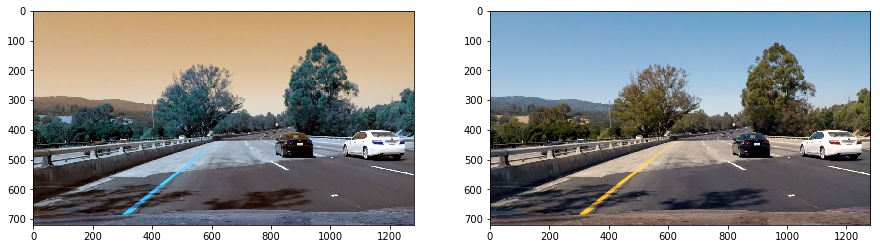

In [3]:
# Process test images
img_file = './test_images/test4.jpg'

img_bgr_original = cv2.imread(img_file)
plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(img_bgr_original)
# cv2.imshow('BGR image',image_original)
# cv2.waitKey(0)  
# cv2.destroyAllWindows() 

img_rgb_original = plt.imread(img_file)
plt.subplot(122)
plt.imshow(img_rgb_original)
plt.show()

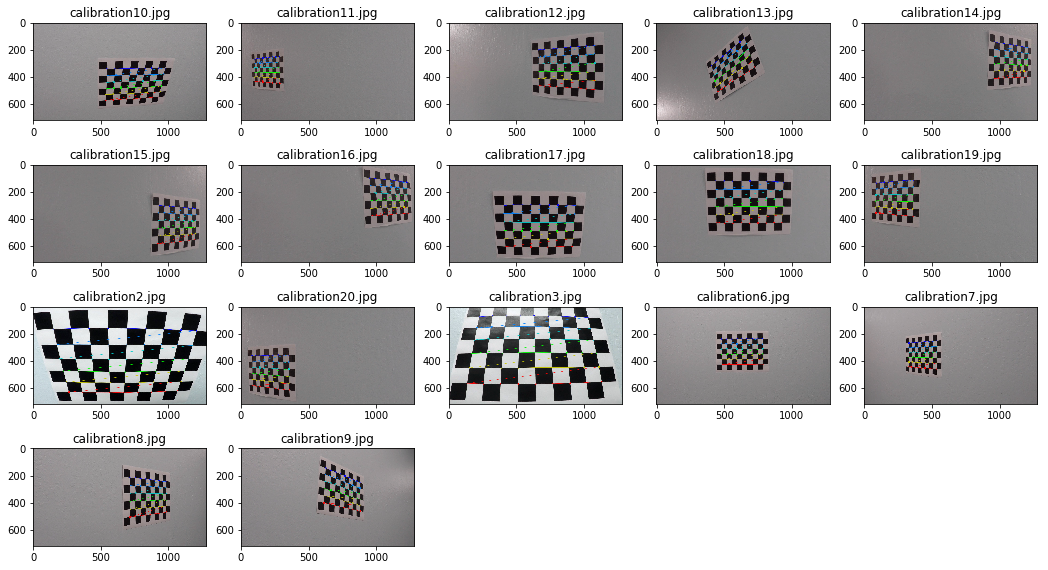

In [4]:
# 1.Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

nx = 9
ny = 6

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((ny*nx,3), np.float32)
# print(objp)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
# print(objp)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

count = 0
plt.figure(1, figsize=(18,10))

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny),None)

    # If found, add object points, image points
    if ret == True:
        count += 1

        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        plt.subplot(4, 5, count)
        plt.title(fname.split('/')[-1])
        plt.imshow(img)

plt.show()

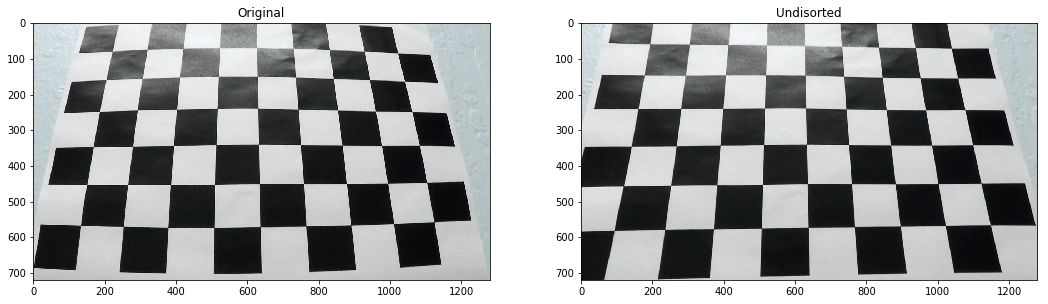

In [5]:
# 2.Apply a distortion correction to raw images.
def undisort(img):
    img_height, img_width, img_channel = img.shape
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (img_width, img_height), None, None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst


#############
# Unit Test #
#############
img_original = cv2.imread('./camera_cal/calibration3.jpg')
img_undisorted = undisort(img_original)

plt.figure(1, figsize=(18,10))
plt.subplot(121)
plt.title('Original')
plt.imshow(img_original)

plt.subplot(122)
plt.title('Undisorted')
plt.imshow(img_undisorted)
plt.show()

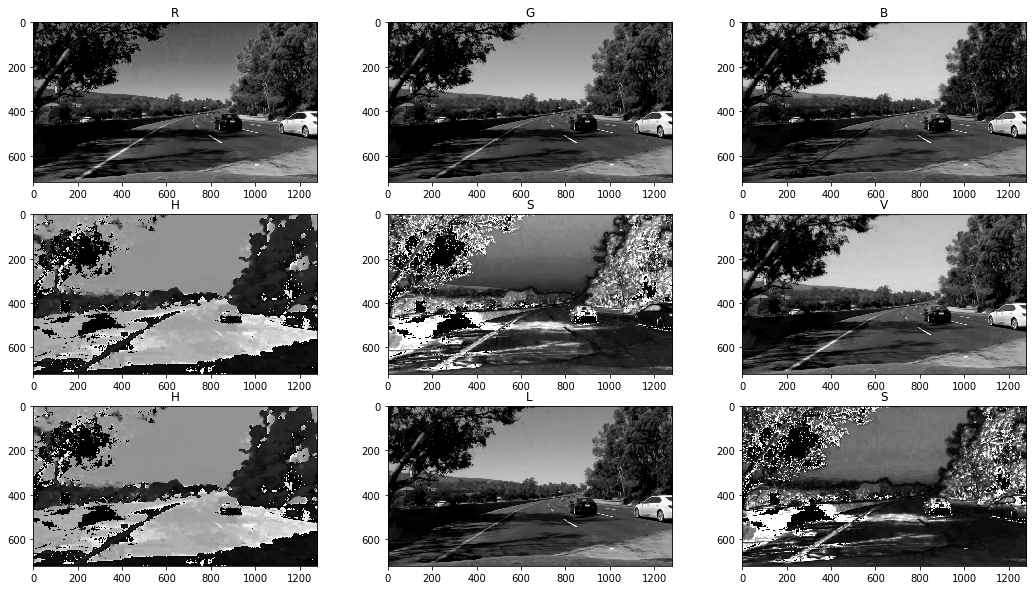

In [221]:
# 3.Use color transforms, gradients, etc., to create a thresholded binary image.
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def binary_rgb(img, orient='x', thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#     gray = img
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return binary_output

def binary_gray(img, orient='x', thresh_min=0, thresh_max=255):
    # Convert to grayscale
#     gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = img
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return binary_output

def binary_mag(img, sobel_kernel=3, thresh_min=0, thresh_max=255):
    # Convert to grayscale
#     gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = img
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    scaled_sobel = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return binary_output

def binary_dir(img, sobel_kernel=3, thresh_min=0, thresh_max=np.pi/2):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    scaled_sobel = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return binary_output

def binary_combination(img_rgb, sobel_kernel=3, thresh_min=0, thresh_max=255):
    img_height, img_width, img_channel = img.shape
    vertices = np.array([[(0,img_height),(int(img_width*0.3), int(img_height*0.65)), (int(img_width*0.7), int(img_height*0.65)), (img_width,img_height)]], dtype=np.int32)
    img_mask = region_of_interest(img=img_rgb, vertices=vertices)
    
#     img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
#     img_blur = cv2.GaussianBlur(img_gray, (5, 5), 0)
    img_hsv = cv2.cvtColor(img_mask, cv2.COLOR_RGB2HSV)
    img_hls = cv2.cvtColor(img_mask, cv2.COLOR_RGB2HLS)
    
    
#     H = img_hsv[:,:,0]
#     S = img_hsv[:,:,1]
    V = img_hsv[:,:,2]
    
    # test1 - V:230 (white)
    # test4 - V:230 (shadow dark white)
    # test5 - V:230 (white shadow wdark)
    # test_challenge - V:190 (shadow dark)
    
    threshold = 230
    # Dark pixels to Black. Dark noises, tree shadows, dark road etc.
    V[(V<threshold)] = 0

    # White pixels to Max
    V[(V>=threshold)] = 1

    # Yellow pixels to Max.
#     S[(H>=22)&(H<=38)] = 255
    
#     R[R < 230] = 0
#     R[R >= 230] = 1
#     result = binary_mag(R, sobel_kernel=sobel_kernel, thresh_min=thresh_min, thresh_max=thresh_max)

    sobel_mag = binary_mag(V, sobel_kernel=sobel_kernel, thresh_min=thresh_min, thresh_max=thresh_max)
#     mpimg.imsave("binary_images/000_bin_V.jpg", V)
#     mpimg.imsave("binary_images/000_bin_sobel_mag.jpg", sobel_mag)

    combined = np.copy(V)
    combined_mag = np.copy(sobel_mag)
    
    sobelx_mask = np.zeros_like(V)
    sobelx_mag = np.zeros_like(V)
    
    img_hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
    V = img_hsv[:,:,2]
    V_gray = V / 255.0
    V_blur = cv2.GaussianBlur(V_gray, (9, 9), 0)
    # mpimg.imsave("binary_images/000_V.jpg", V)
    # mpimg.imsave("binary_images/000_V_gray.jpg", V_gray)
    # mpimg.imsave("binary_images/000_V_blur.jpg", V_blur)
    sobelx = binary_gray(V_blur, orient='x', thresh_min=50, thresh_max=thresh_max)
    sobelx_mask = region_of_interest(img=sobelx, vertices=vertices)
    # sobelx_mag = binary_mag(sobelx_mask, sobel_kernel=sobel_kernel, thresh_min=thresh_min, thresh_max=thresh_max)
    # mpimg.imsave("binary_images/000_0.jpg", img_rgb)
    # mpimg.imsave("binary_images/000_0.jpg", img_rgb)
#     mpimg.imsave("binary_images/000_a_50.jpg", sobelx_mask)
#     mpimg.imsave("binary_images/000_sobelx_b.jpg", sobelx_mask)
#     mpimg.imsave("binary_images/000_sobelx_mag.jpg", sobelx_mag)
    combined[sobelx_mask == 1] = 1
    combined_mag = binary_mag(combined, sobel_kernel=sobel_kernel, thresh_min=thresh_min, thresh_max=thresh_max)
    
#     numb_line_pixels = np.sum(V)
#     if numb_line_pixels < 2000:
# #         print(numb_line_pixels)
#         combined_mag = binary_mag(combined, sobel_kernel=sobel_kernel, thresh_min=thresh_min, thresh_max=thresh_max)
        
    # mpimg.imsave("binary_images/{}_result_V+sobelx.jpg".format(str(numb_line_pixels)), combined)
    # mpimg.imsave("binary_images/{}_result_V+sobelx_mag.jpg".format(str(numb_line_pixels)), result)
        
    return combined, combined_mag


#############
# Unit Test #
#############
img_file = './test_images/test_challenge.jpg'
img_name, img_ext = os.path.splitext(img_file.split('/')[-1])
img_original = plt.imread(img_file)
img_undisorted = undisort(img_original)
img_binary, img_binary_mag = binary_combination(img_undisorted, sobel_kernel=3, thresh_min=100, thresh_max=255)

# RGB
plt.figure(1, figsize=(18,10))
plt.subplot(3,3,1)
plt.title('R')
plt.imshow(img_undisorted[:,:,0], cmap='gray')

plt.subplot(3,3,2)
plt.title('G')
plt.imshow(img_undisorted[:,:,1], cmap='gray')

plt.subplot(3,3,3)
plt.title('B')
plt.imshow(img_undisorted[:,:,2], cmap='gray')

# HSV
img_hsv = cv2.cvtColor(img_undisorted, cv2.COLOR_RGB2HSV)
plt.figure(1, figsize=(18,10))
plt.subplot(3,3,4)
plt.title('H')
plt.imshow(img_hsv[:,:,0], cmap='gray')

plt.subplot(3,3,5)
plt.title('S')
plt.imshow(img_hsv[:,:,1], cmap='gray')

plt.subplot(3,3,6)
plt.title('V')
plt.imshow(img_hsv[:,:,2], cmap='gray')

# HLS
img_hls = cv2.cvtColor(img_undisorted, cv2.COLOR_RGB2HLS)
plt.figure(1, figsize=(18,10))
plt.subplot(3,3,7)
plt.title('H')
plt.imshow(img_hls[:,:,0], cmap='gray')

plt.subplot(3,3,8)
plt.title('L')
plt.imshow(img_hls[:,:,1], cmap='gray')

plt.subplot(3,3,9)
plt.title('S')
plt.imshow(img_hls[:,:,2], cmap='gray')
plt.show()

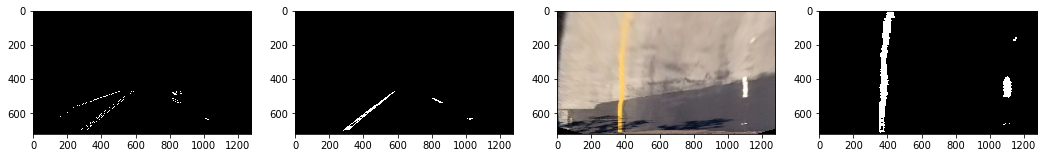

In [206]:
# 4.Apply a perspective transform to rectify binary image ("birds-eye view").
left_line_last = [(0,0),(0,0)]
right_line_last = [(0,0),(0,0)]
left_no_line = False
right_no_line = False
def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
#     print ('lines: ',len(lines))
    global left_line_last
    global right_line_last
    global left_no_line
    global right_no_line
    
    image_height, image_width, image_channel = img.shape
    
    slope_low = 0.4
    slope_high = 1.0
    y_top = int(image_height * 0.65)
    y_bottom = int(image_height - 1)
#     print(y_top, y_bottom)
    
    arr_slope_left = list()
    arr_slope_right = list()
    arr_x_left = list()
    arr_y_left = list()
    arr_x_right = list()
    arr_y_right = list()
    
    if lines is not None:
        for line in lines:
            for x1,y1,x2,y2 in line:
                slope = (y2-y1)/(x2-x1)
                distance = ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5
                x_average = (x1 + x2) / 2
                y_average = (y1 + y2) / 2
    #             print (x1,y1,x2,y2,slope,distance,x_average,y_average)

                # left lane lines
                if slope > -slope_high and slope < -slope_low:
                    arr_slope_left.append(slope)
                    arr_x_left.append(x_average)
                    arr_y_left.append(y_average)

                # right lane lines
                if slope > slope_low and slope < slope_high:
                    arr_slope_right.append(slope)
                    arr_x_right.append(x_average)
                    arr_y_right.append(y_average)
                
#     print(slope_left)
#     print(slope_right)
#     print(np.mean(arr_slope_left), np.mean(arr_x_left), np.mean(arr_y_left))
#     print(np.mean(arr_slope_right), np.mean(arr_x_right), np.mean(arr_y_right))

    # calculate average of slope, x, y
    slope_left = np.mean(arr_slope_left)
    x_left = np.mean(arr_x_left)
    y_left = np.mean(arr_y_left)
    
    slope_right = np.mean(arr_slope_right)
    x_right = np.mean(arr_x_right)
    y_right = np.mean(arr_y_right)
    
    corners = [[],[],[],[]]
    
    if len(arr_slope_left) > 0:
        left_no_line = False
        # calculate left x1,y1,x2,y2
        x_top = (y_top - y_left) / slope_left + x_left
        x_bottom = x_left - (y_left - y_bottom) / slope_left
        # draw left line
        cv2.line(img, (int(x_bottom), int(y_bottom)), (int(x_top), int(y_top)), color, thickness)
        
        corners[2] = [int(x_bottom), int(y_bottom)]
        corners[0] = [int(x_top), int(y_top)]
        
        left_line_last[0] = (int(x_bottom), int(y_bottom))
        left_line_last[1] = (int(x_top), int(y_top))
    else:
        print('No left line warning')
        left_no_line = True
        
        x_bottom, y_bottom = left_line_last[0]
        x_top, y_top = left_line_last[1]
        
        cv2.line(img, (int(x_bottom), int(y_bottom)), (int(x_top), int(y_top)), color, thickness)
        
        corners[2] = [int(x_bottom), int(y_bottom)]
        corners[0] = [int(x_top), int(y_top)]
    
    color=[0, 0, 255]
    if len(arr_slope_right) > 0:
        right_no_line = False
        # calculate right x1,y1,x2,y2
        x_top = x_right - (y_right - y_top) / slope_right
        x_bottom = (y_bottom - y_right) / slope_right + x_right
        # draw right line
        cv2.line(img, (int(x_top), int(y_top)), (int(x_bottom), int(y_bottom)), color, thickness)
        
        corners[1] = [int(x_top), int(y_top)]
        corners[3] = [int(x_bottom), int(y_bottom)]
        
        right_line_last[0] = (int(x_bottom), int(y_bottom))
        right_line_last[1] = (int(x_top), int(y_top))
    else:
#         print('No right line warning')
        right_no_line = True
        
        x_bottom, y_bottom = right_line_last[0]
        x_top, y_top = right_line_last[1]
        
        cv2.line(img, (int(x_top), int(y_top)), (int(x_bottom), int(y_bottom)), color, thickness)
        
        corners[1] = [int(x_top), int(y_top)]
        corners[3] = [int(x_bottom), int(y_bottom)]
        
    return corners

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    corners = draw_lines(line_img, lines)
    return line_img, corners

def detect_lines(img):
    img_height, img_width = img.shape
#     print(np.min(img), np.max(img))

    thresh_area = 10
    slope_low = 0.4
    slope_high = 1.0
    y_top = int(img_height * 0.65)
    y_bottom = int(img_height - 1)
    
    line_img = np.zeros((img_height, img_width, 3), dtype=np.uint8)
#     img = cv2.imread(img_file, 0)
    ret, thresh = cv2.threshold(img, 0.5, 1, cv2.THRESH_BINARY)
    _, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    left = list()
    right = list()
#     print(len(contours))
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area >= thresh_area:
            rect = cv2.minAreaRect(cnt)
            box = cv2.boxPoints(rect)
            box = np.int0(box)
#             img = cv2.drawContours(img,[box],0,(255,0,0),2)

            x1,y1,x2,y2 = 0,0,0,0
            x3,y3 = 0,0
            x_bottom = 0
            if box[0][0] < 640:
                x1 = box[1][0]
                y1 = box[1][1]
                x2 = box[2][0]
                y2 = box[2][1]
                x3 = box[0][0]
                y3 = box[0][1]
            else:
                x1 = box[3][0]
                y1 = box[3][1]
                x2 = box[2][0]
                y2 = box[2][1]
                x3 = box[0][0]
                y3 = box[0][1]
            slope = (y2 - y1) / (x2 - x1) if x2-x1 != 0 else 0
            long = ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5
            short = ((x1 - x3) ** 2 + (y1 - y3) ** 2) ** 0.5
            x_bottom = (x1+x3)/2 - ((y1+y3)/2 - y_bottom) / slope if slope != 0 else 0
#             print(area, x_bottom, slope)

            if slope > -slope_high and slope < -slope_low and long > short*2:
                left.append((area, x_bottom, slope))
#                 img = cv2.drawContours(img,[box],0,(255,0,0),2)
            if slope > slope_low and slope < slope_high and long > short*2:
                right.append((area, x_bottom, slope))
#                 img = cv2.drawContours(img,[box],0,(255,0,0),2)

#     if len(left) == 0
#         left_line_last[0] = (int(x_bottom), int(y_bottom))
#         left_line_last[1] = (int(x_top), int(y_top))
        
    area_sum, slope_sum, x_sum = 0, 0, 0
    for item in left:
        area_sum += item[0]
        x_sum += item[1] * item[0]
        slope_sum += item[2] * item[0]
    slope_left = slope_sum / area_sum
    x_left_bottom = int(x_sum / area_sum)
    x_left_top = int((y_top - y_bottom) / slope_left + x_left_bottom)

    area_sum, slope_sum, x_sum = 0, 0, 0
    for item in right:
        area_sum += item[0]
        x_sum += item[1] * item[0]
        slope_sum += item[2] * item[0]
    slope_right = slope_sum / area_sum
    x_right_bottom = int(x_sum / area_sum)
    x_right_top = int((y_top - y_bottom) / slope_right + x_right_bottom)

    cv2.line(line_img, (x_left_top, y_top), (x_left_bottom, y_bottom), (255,0,0), 5)
    cv2.line(line_img, (x_right_top, y_top), (x_right_bottom, y_bottom), (0,0,255), 5)
    
    corners = [[],[],[],[]]
    corners[2] = [x_left_bottom, y_bottom]
    corners[0] = [x_left_top, y_top]
    corners[3] = [x_right_bottom, y_bottom]
    corners[1] = [x_right_top, y_top]
    
    return line_img, corners

def clear_line_noise(img, corners):
    x_left_bottom, y_bottom = corners[2]
    x_left_top, y_top = corners[0]
    x_right_bottom, y_bottom = corners[3]
    x_right_top, y_top = corners[1]
    
    leftx = [x_left_bottom, x_left_top]
    lefty = [y_bottom, y_top]
    rightx = [x_right_bottom, x_right_top]
    righty = lefty
    
    left_fit = np.polyfit(lefty, leftx, 1)
    right_fit = np.polyfit(righty, rightx, 1)
    
    ploty = np.linspace(0, y_bottom, y_bottom + 1)
#     print(ploty)
    left_fitx = left_fit[0]*ploty + left_fit[1]
    right_fitx = right_fit[0]*ploty + right_fit[1]
#     print(left_fitx)

    # Set the width of the windows +/- margin
    margin = 100
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
#     print(len(nonzeroy),len(nonzerox))
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Step through the windows one by one
    for y in range(int(0.65*y_bottom), y_bottom+1, 1):
#         print(y)
#         left_base = [left_fitx[y],y]
#         right_base = [right_fitx[y],y]
        leftx_low = left_fitx[y] - margin / 2
        leftx_high = left_fitx[y] + margin / 2
        rightx_low = right_fitx[y] - margin / 2
        rightx_high = right_fitx[y] + margin / 2
        
        good_left_inds = ((nonzeroy == y) & (nonzerox > leftx_low) &  (nonzerox <= leftx_high)).nonzero()[0]
        good_right_inds = ((nonzeroy == y) & (nonzerox >= rightx_low) &  (nonzerox < rightx_high)).nonzero()[0]
#         print(len(good_left_inds),len(good_right_inds))
#         print(good_left_inds)
#         print(nonzerox[good_left_inds[0]],nonzeroy[good_left_inds[0]])
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
#     print(len(left_lane_inds), len(right_lane_inds))

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    img_binary_clear = np.zeros_like(img)
    img_binary_clear[lefty, leftx] = 1
    img_binary_clear[righty, rightx] = 1
#     mpimg.imsave('./binary_line/41_{}_clear.jpg'.format(str(count)), img_clear)

    return img_binary_clear

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def perspective(img, src, dst):
    # Grab the image shape
    img_height = img.shape[0]
    img_width = img.shape[1]

#     src = np.float32(src)
#     dst = np.float32(dst)
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img_width, img_height))
    
    return warped


#############
# Unit Test #
#############
img_file = './test_images/test4.jpg'
img_name, img_ext = os.path.splitext(img_file.split('/')[-1])
img_original = plt.imread(img_file)
img_undisorted = undisort(img_original)
img_binary, img_binary_mag = binary_combination(img_undisorted, sobel_kernel=3, thresh_min=100, thresh_max=255)


# # Hough Transform detect lane lines
# # Define the Hough transform parameters
# rho = 1 # distance resolution in pixels of the Hough grid
# theta = np.pi/180 # angular resolution in radians of the Hough grid
# threshold = 20     # minimum number of votes (intersections in Hough grid cell)
# min_line_length = 40 #minimum number of pixels making up a line
# max_line_gap = 20    # maximum gap in pixels between connectable line segments
# # Output "lines" is an array containing endpoints of detected line segments
# lines, corners = hough_lines(img=img_binary, rho=rho, theta=theta, threshold=threshold, min_line_len=min_line_length, max_line_gap=max_line_gap)
# # Draw lane lines on the image
# img_line = weighted_img(img=lines, initial_img=img_undisorted)

lines, corners = detect_lines(img_binary_mag)
img_binary_clear = clear_line_noise(img_binary, corners)
img_line = weighted_img(img=lines, initial_img=img_undisorted)
# img_line = weighted_img(img=lines, initial_img=img_mask)
# mpimg.imsave("binary_images/binary_0.png", img_binary)
# mpimg.imsave("binary_images/binary_1.png", img_line)

plt.figure(1, figsize=(18,10))
plt.subplot(141)
plt.imshow(img_binary_mag, cmap='gray')
plt.subplot(142)
plt.imshow(img_binary_clear, cmap='gray')
# plt.subplot(142)
# plt.imshow(img_line)

offset = 100
src = np.float32(corners)
dst = np.float32([[corners[2][0]+offset,0], [corners[3][0]-offset,0], [corners[2][0]+offset,img_height], [corners[3][0]-offset,img_height]])
# print(src)
# print(dst)
img_warped = perspective(img_undisorted, src, dst)
# img_warped_binary = perspective(img_binary, src, dst)
img_warped_binary = perspective(img_binary_clear, src, dst)

plt.subplot(143)
plt.imshow(img_warped)
plt.subplot(144)
plt.imshow(img_warped_binary, cmap='gray')
plt.show()

Curvature:  1923.99147376 m,
Plolyfit:  [  8.53573510e-05  -1.18011034e-01   4.09317137e+02] [  2.82888218e-04  -3.22548014e-01   1.18780874e+03]


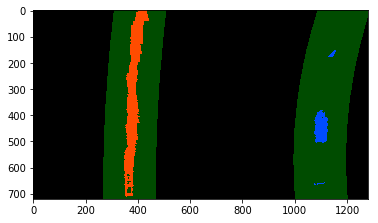

In [197]:
# 5.Detect lane pixels and fit to find the lane boundary.
# 6.Determine the curvature of the lane and vehicle position with respect to center.
left_fit_last = []
right_fit_last = []
left_fit_cr_last = []
right_fit_cr_last = []

def search_new_fit(binary_warped):
    histogram = np.sum(binary_warped, axis=0)
#     histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # print(binary_warped.shape, binary_warped[360:].shape, histogram.shape)
    # plt.plot(histogram)
    # plt.show()

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return (leftx,lefty,rightx,righty)

def search_near_fit(binary_warped):
    left_fit = left_fit_last
    right_fit = right_fit_last
    
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return (leftx,lefty,rightx,righty)

def fit_measure(img):
    global left_no_line
    global right_no_line
    global left_fit_last
    global right_fit_last
    global left_fit_cr_last
    global right_fit_cr_last
#     print(left_fit_last, right_fit_last)

    left_fit = []
    right_fit = []
    leftx = []
    lefty = []
    rightx = []
    righty = []
    
    binary_warped = img
    (leftx,lefty,rightx,righty) = search_new_fit(binary_warped)
    
#     if (left_fit_last == []) or (right_fit_last == []):
# #         print('Search a new fit')
#         (leftx,lefty,rightx,righty) = search_new_fit(binary_warped)
#     else:
# #         print('Search nearest fit')
#         (leftx,lefty,rightx,righty) = search_near_fit(binary_warped)

    if (len(leftx) == 0) or (len(lefty) == 0):
        left_fit = left_fit_last
    else:
        left_fit = np.polyfit(lefty, leftx, 2)
    if (len(rightx) == 0) or (len(righty) == 0):
        right_fit = right_fit_last
    else:
        right_fit = np.polyfit(righty, rightx, 2)
    left_fit_last = left_fit
    right_fit_last = right_fit

    #################
    # Visualization #
    #################
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)

#     out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
#     out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
#     plt.imshow(out_img)
    
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    margin = 100
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
#     plt.imshow(result)
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')
#     plt.xlim(0, 1280)
#     plt.ylim(720, 0)
#     plt.show()

    ###########
    # Measure #
    ###########
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    # print(left_curverad, right_curverad)
    # Example values: 1926.74 1908.48

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

#     print(len(leftx), len(ploty))
    # Fit new polynomials to x,y in world space
#     left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
#     right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    if (left_no_line == True) or (len(leftx) == 0) or (len(lefty) == 0):
        left_fit_cr = left_fit_cr_last
    else:
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    if (right_no_line == True) or (len(rightx) == 0) or (len(righty) == 0):
        right_fit_cr = right_fit_cr_last
    else:
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    left_fit_cr_last = left_fit_cr
    right_fit_cr_last = right_fit_cr
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    curverad = np.min([left_curverad, right_curverad])
    # Now our radius of curvature is in meters
#     print(left_curverad, 'm', right_curverad, 'm', curverad)
    # Example values: 632.1 m    626.2 m
    
    left_fit_bottom_point_x = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
    right_fit_bottom_point_x = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
    vihicle_center_x = np.average([left_fit_bottom_point_x, right_fit_bottom_point_x])
    distance = (vihicle_center_x - img_width / 2) * xm_per_pix
#     print(left_fit_bottom_point_x, right_fit_bottom_point_x, vihicle_center_x, vihicle_center_x - img_width / 2, xm_per_pix, distance)
    
    return result, left_curverad, distance, (left_fit, right_fit)

#############
# Unit Test #
#############
img_fit, curverad, distance, (left_fit, right_fit)  = fit_measure(img_warped_binary)
print('Curvature: ', curverad,'m,')
print('Plolyfit: ', left_fit, right_fit)
plt.imshow(img_fit)
plt.show()

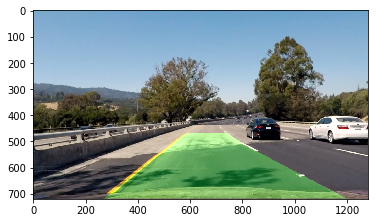

In [168]:
# 7.Warp the detected lane boundaries back onto the original image.
def draw_lane(img_warped_binary, img_undisorted, dst, src, left_fit, right_fit):
    warped = img_warped_binary
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
#     color_warp = cv2.addWeighted(img_fit, 1, color_warp, 1, 0)

    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img_undisorted.shape[1], img_undisorted.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img_undisorted, 1, newwarp, 0.3, 0)
    
    return result

#############
# Unit Test #
#############
img_lane = draw_lane(img_warped_binary, img_undisorted, dst, src, left_fit, right_fit)
# img_lane = draw_lane(img_warped_binary, img_line, dst, src, left_fit, right_fit)
mpimg.imsave("output_images/{}_lane.jpg".format(img_name), img_lane)
plt.imshow(img_lane)
plt.show()

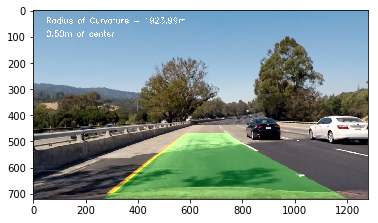

In [169]:
# 8.Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
def draw_measure(img, curvature, distance):
    str1 = 'Radius of Curvature = {0:.2f}m'.format(curvature)
    str2 = '{0:.2f}m of center'.format(distance)
    result = cv2.putText(img, str1, (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255 ,255), thickness = 2)
    result = cv2.putText(result, str2, (50,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255 ,255), thickness = 2)
    return result

#############
# Unit Test #
#############
img_final = draw_measure(img_lane, curverad, distance)
mpimg.imsave("output_images/{}_final.jpg".format(img_name), img_lane)
plt.imshow(img_final)
plt.show()

In [219]:
####################
# Process Pipeline #
####################
def pipeline_reset():
    global left_line_last
    global right_line_last
    global left_fit_last
    global right_fit_last
    global left_fit_cr_last
    global right_fit_cr_last
    global left_no_line
    global right_no_line
    left_line_last = [(0,0),(0,0)]
    right_line_last = [(0,0),(0,0)]
    left_fit_last = []
    right_fit_last = []
    left_fit_cr_last = []
    right_fit_cr_last = []
    left_no_line = False
    right_no_line = False

frame = 1
# (Done first) 1.Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
def pipeline(img):
    # 2.Apply a distortion correction to raw images.
#     img_original = plt.imread(img)
#     img_original = cv2.imread(img)
    img_original = img
    img_undisorted = undisort(img_original)
    
    
    # 3.Use color transforms, gradients, etc., to create a thresholded binary image.
    img_binary, img_binary_mag = binary_combination(img_undisorted, sobel_kernel=3, thresh_min=100, thresh_max=255)
    
    
    # 4.Apply a perspective transform to rectify binary image ("birds-eye view").
    lines, corners = detect_lines(img_binary_mag)
    img_binary_clear = clear_line_noise(img_binary, corners)
    img_line = weighted_img(img=lines, initial_img=img_undisorted)
    
    offset = 150
    src = np.float32(corners)
    dst = np.float32([[corners[2][0]+offset,0], [corners[3][0]-offset,0], [corners[2][0]+offset,img_height], [corners[3][0]-offset,img_height]])
    # print(src)
    # print(dst)
    # img_warped = perspective(img_undisorted, src, dst)
#     img_warped_binary = perspective(img_binary, src, dst)
    img_warped_binary = perspective(img_binary_clear, src, dst)
    
    
    # 5.Detect lane pixels and fit to find the lane boundary.
    # 6.Determine the curvature of the lane and vehicle position with respect to center.
    img_fit, curverad, distance, (left_fit, right_fit)  = fit_measure(img_warped_binary)
    # print('Curvatures: ', left_curverad,'m,', right_curverad,'m')
    # print('Plolyfit: ', left_fit, right_fit)

    
    # 7.Warp the detected lane boundaries back onto the original image.
    img_lane = draw_lane(img_warped_binary, img_undisorted, dst, src, left_fit, right_fit)
    
    
    # 8.Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
    img_final = draw_measure(img_lane, curverad, distance)
    
    
#     global frame
#     second = 0
#     mpimg.imsave("binary_images/0{}_{}_0.jpg".format(str(second),str(frame)), img_undisorted)
#     mpimg.imsave("binary_images/0{}_{}_1.jpg".format(str(second),str(frame)), img_binary)
#     mpimg.imsave("binary_images/0{}_{}_2.jpg".format(str(second),str(frame)), img_binary_mag)
#     mpimg.imsave("binary_images/0{}_{}_3.jpg".format(str(second),str(frame)), img_binary_clear)
#     mpimg.imsave("binary_images/0{}_{}_4.jpg".format(str(second),str(frame)), img_fit)
#     mpimg.imsave("binary_images/0{}_{}_5.jpg".format(str(second),str(frame)), img_lane)
#     mpimg.imsave("binary_images/0{}_{}_6.jpg".format(str(second),str(frame)), img_final)
#     frame += 1
    
    return img_final

In [220]:
#######################
# Process test images #
#######################
images = glob.glob('./test_images/*.jpg')
for img_file in images:
    print('Process: ',img_file)
    
    # reset parameter
    pipeline_reset()
    
    # pipeline
    img_name, img_ext = os.path.splitext(img_file.split('/')[-1])
    img_original = plt.imread(img_file)
    img_final = pipeline(img_original)
    
    mpimg.imsave("output_images/{}_final.jpg".format(img_name), img_final)

Process:  ./test_images/straight_lines1.jpg
Process:  ./test_images/straight_lines2.jpg
Process:  ./test_images/test1.jpg
Process:  ./test_images/test2.jpg
Process:  ./test_images/test3.jpg
Process:  ./test_images/test4.jpg
Process:  ./test_images/test5.jpg
Process:  ./test_images/test6.jpg
Process:  ./test_images/test_challenge.jpg


In [31]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [214]:
#############################
# Process project_video.mp4 #
#############################

# reset parameter
pipeline_reset()

white_output = './project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip1 = VideoFileClip("./project_video.mp4").subclip(31,32)
clip1 = VideoFileClip("./project_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False, progress_bar=False)
print('project_video_output.mp4 finished!')

[MoviePy] >>>> Building video ./project_video_output.mp4
[MoviePy] Writing video ./project_video_output.mp4
[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_output.mp4 

CPU times: user 23min 52s, sys: 1min 23s, total: 25min 15s
Wall time: 21min 28s
project_video_output.mp4 finished!


In [218]:
###############################
# Process challenge_video.mp4 #
###############################

# reset parameter
pipeline_reset()

white_output = './challenge_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("./challenge_video.mp4").subclip(0,1)
# clip1 = VideoFileClip("./challenge_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False, progress_bar=True)
print('challenge_video_output.mp4 finished!')

[MoviePy] >>>> Building video ./challenge_video_output.mp4
[MoviePy] Writing video ./challenge_video_output.mp4



100%|██████████| 30/30 [00:30<00:00,  1.02it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./challenge_video_output.mp4 

CPU times: user 33.3 s, sys: 2.13 s, total: 35.4 s
Wall time: 31.5 s
challenge_video_output.mp4 finished!
